In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQ_in_ML.examples_utils import *
from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
fontsize = 14
set_labels = lambda x: (x.set_xlabel('input X', fontsize=fontsize) and x.set_ylabel('output y', fontsize=fontsize))

## Choose a problem

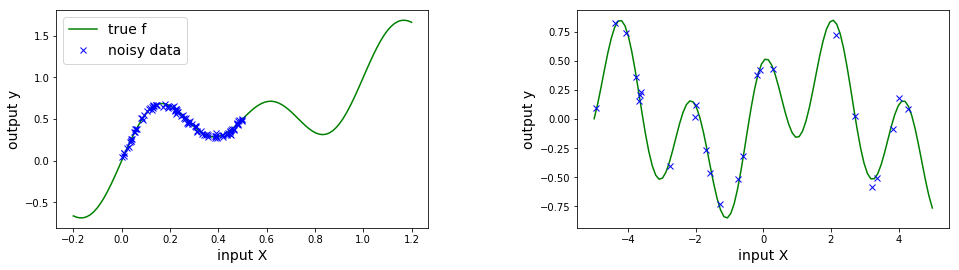

In [3]:
n_problems = 2
input_dicts = [{'problem': 'linear_sin', 'n_data': 100},
               {'problem': 'cos_sin', 'n_data': 25}]
for j, d in enumerate(input_dicts):
    d_out = set_problem(**d, as_dict=True)
    d.update(d_out)

fig, ax = plt.subplots(figsize=(8*n_problems,4), ncols=n_problems)
for j, d in enumerate(input_dicts):
    ax[j].plot(d['x_plot'], d['y_plot'], color='green', label='true f')
    ax[j].plot(d['xn'], d['yn'], color='blue', linestyle='none', marker='x', label='noisy data')
    set_labels(ax[j])
ax[0].legend(fontsize=fontsize)
plt.subplots_adjust(wspace=0.4, hspace=0)
plt.show(fig)

## Set a network architecture and prior over the weights
Also, look at the effect of the prior on the network

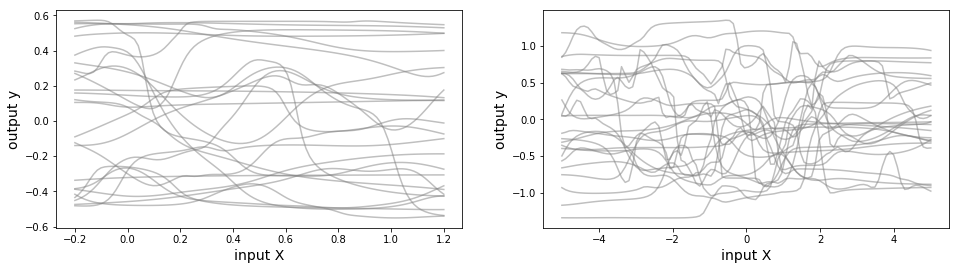

In [4]:
fig, ax = plt.subplots(figsize=(8*n_problems,4), ncols=n_problems)
for j, d in enumerate(input_dicts):
    units_per_layer, prior, pre_model = set_default_network(problem=d['problem'], X_train=d['xn'], as_dict=False)
    d.update({'units_per_layer': units_per_layer, 'prior': prior, 'pre_model': pre_model})
    
    # Set a regressor and sample from the prior
    reg = MAPRegressor(units_per_layer=units_per_layer, prior=prior, pre_model=pre_model, input_dim=1, output_dim=1, 
                    var_n=d['var_n'], activation='tanh')
    y_prior = reg.predict_from_prior(X=d['x_plot'], ns=25)
    for yp in y_prior[:,0,:].T:
        ax[j].plot(d['x_plot'], yp, color='gray', alpha=0.5)
        set_labels(ax[j])

In [5]:
import tensorflow as tf
A = tf.Variable(tf.random_normal(shape=(2, 3)+(1,), mean=2., stddev=1.), dtype=tf.float32)
B = tf.tile(A, [1, 1, 4])
sess = tf.Session()
with sess.as_default():
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    print(sess.run(B[:,:,0]))
    print(sess.run(B[:,:,1]))
    print(sess.run(A))
    print(sess.run(tf.divide(A,A)))

[[1.4765565 0.8328059 2.1821334]
 [0.632146  2.3152196 3.4138136]]
[[1.4765565 0.8328059 2.1821334]
 [0.632146  2.3152196 3.4138136]]
[[[1.4765565]
  [0.8328059]
  [2.1821334]]

 [[0.632146 ]
  [2.3152196]
  [3.4138136]]]
[[[1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]]]


In [6]:
A = (2, 3)
print(np.prod(A))
print(type(int(np.prod(A))))
print(len((3,)))

6
<class 'int'>
1


[0.013226744, 0.045590878, 0.012802081, 0.08369773, 0.23510708, 0.081816435, 0.2896722, 0.325476, 0.18283863, 0.11275004, 0.6002847, 0.24627651, 0.005247154, 0.004919212, 0.003009911]
[0.11044702, 0.019482445, 0.05828696, 0.40692896, 0.56604755, 0.76919824, 0.2859701, 0.4308941, 0.5240191, 0.6178953, 1.1185724, 1.071661, 0.010013347, 0.0112848105, 0.012434341]


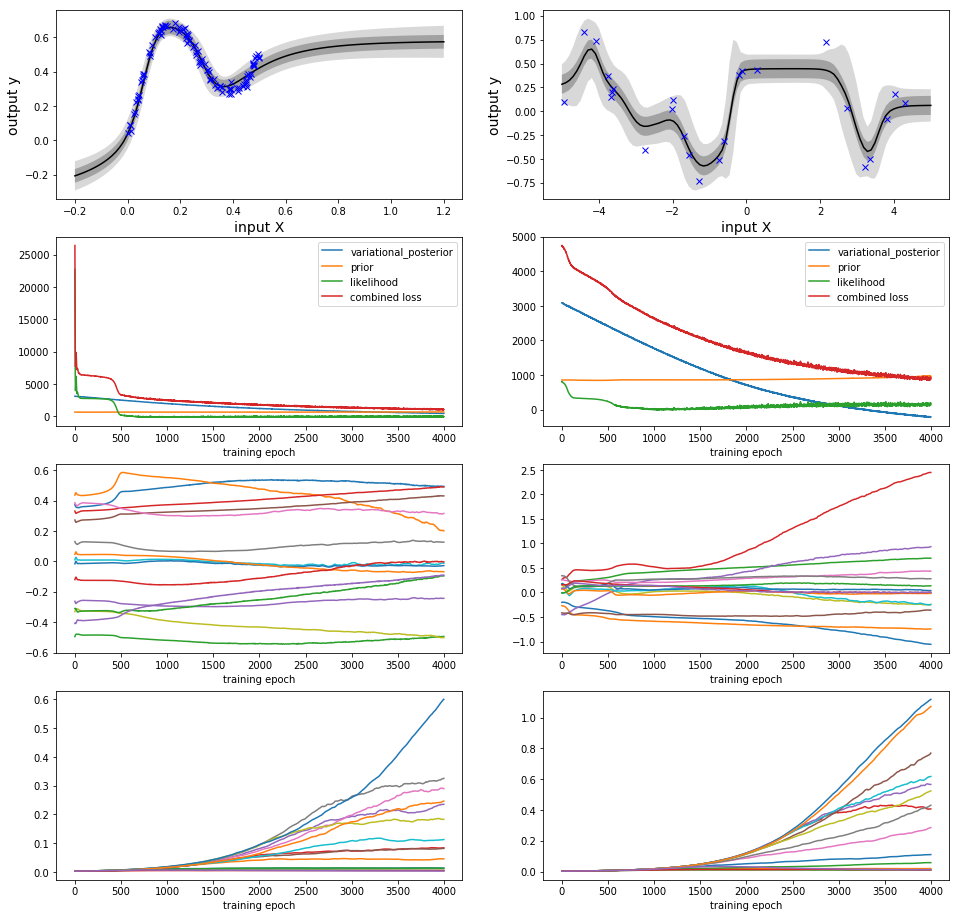

In [11]:
# Bayes By Backprop
titles_losses = ['variational_posterior', 'prior', 'likelihood', 'combined loss']
fig, ax = plt.subplots(figsize=(8*n_problems,4*4), ncols=n_problems, nrows=4)
for j, d in enumerate(input_dicts):
    #tf.reset_default_graph()
    # Set a MCMC based regressor
    reg = BayesByBackprop(units_per_layer=d['units_per_layer'], prior=d['prior'], pre_model=d['pre_model'], 
                          input_dim=1, output_dim=1, 
                          var_n=d['var_n'], activation='tanh')
    reg.fit(X=d['xn'], y=d['yn'], ns=10, verbose=False, epochs=4000, lr=0.002)
    y_pred, y_std, _ = reg.predict_UQ(X=d['x_plot'], ns=100, output_MC=False)
    #ax[j].plot(d['x_plot'], y_pred, color='pink')
    #ax[j].plot(d['xn'], d['yn'], marker='.', color='blue', linestyle='none')
    
    plot_mean_2sigma(x=d['x_plot'].reshape((-1)), y_mean=y_pred.reshape((-1,)), y_std=y_std.reshape((-1,)),
                     var_n=d['var_n'], ax=ax[0][j])
    ax[0][j].plot(d['xn'], d['yn'], color='blue', linestyle='none', marker='x', label='noisy data')
    set_labels(ax[0][j])
    
    # plot the values of the losses
    for i in range(4):
        ax[1][j].plot(reg.loss_history[:, i], label=titles_losses[i])
        ax[1][j].set_xlabel('training epoch')
        ax[1][j].legend()
        
    # plot the values of the parameters
    for i in range(reg.means_history.shape[1]):
        ax[2][j].plot(reg.means_history[:, i])
        ax[2][j].set_xlabel('training epoch')
        ax[3][j].plot(reg.stds_history[:, i])
        ax[3][j].set_xlabel('training epoch')

## Full Bayesian inference -> MCMC

import pickle
fig, ax = plt.subplots(figsize=(8*n_problems,4), ncols=n_problems)
for j, d in enumerate(input_dicts):
    # Set a MCMC based regressor
    reg = MCMCRegressor(units_per_layer=d['units_per_layer'], prior=d['prior'], pre_model=d['pre_model'], 
                        input_dim=1, output_dim=1, 
                        var_n=d['var_n'], activation='tanh',
                        algorithm='am', n_chains=1, ns=1000, burnin=1000, jump=5)
    reg.fit(X=d['xn'], y=d['yn'])
    with open('test_MCMC_vary[problem='+d['problem']+']_May8_test.pkl', 'wb') as handle:
        pickle.dump(reg.samples, handle)
    y_pred = reg.predict(X=d['x_plot'])
    ax[j].plot(d['x_plot'], y_pred, color='pink')
    ax[j].plot(d['xn'], d['yn'], marker='.', color='blue', linestyle='none')

In [8]:
with open('test_MCMC_vary[problem=linear_sin].pkl', 'rb') as handle:
    s = pickle.load(handle)
print(s.shape)

NameError: name 'pickle' is not defined

## MC dropout

## BayesByBackprop

In [ ]:
## Ensembles with randomized prior functions